In [1]:
import pickle
import cv2
import matplotlib.pyplot as plt
from simMat import *

plt.rcParams['figure.figsize'] = (12,12)

dataPath = '../Data/'
simMat_yr = np.load(dataPath + 'history_simMat.npy')
min_yr = 1771

fh = open(f'./Genetic1D/bestIndivs_yearly.gen', 'rb') 
Indivs_yr = pickle.load(fh)

def genToElem(gen):
    """func to convert a gen (list of positions) into sequence of reshuffled elements"""
    order = ['_' for i in range(103)]
    for i,idx in enumerate(gen):
        order[idx] = elemList_AO[i]
    return order

# Issues to address here:


- Automatically find groups

- How early do such groups arise?
    - Show evolution of such groups through history (ranking-like)

#### Idea 2:
- Use the optimized scales to reshuffle the matrix, which leads to a diagonal-like matrix.
- Use computer vision techniques to identify squares in the diagonal.

---

In the following, I implement the second idea, as it looks more doable and relies, in principle, on existing software (or mathemathics).

## Exploring the tools in the opencv library.

---

### Image preprocessing:

- Produce reshuffled image using a particular individual out of the 20 obtained for a particular year.
- Convert to int in range 0 - 255
- Upsample: Resize image by factor US_FACT, to increase amount of pixels and detect sharper edges.
- blur: Convolutional average, to remove sharp edges from fluctuations.
- padd: add a frame to the image, so edges are detected on the edges of the image (if any)
- Canny: Canny edge detection algorithm. Detect edges using gradient-based criteria.

### Next, using the edges detected, let's now detect contours (closed figures in the image)

Function cv2.findContours takes 3 inputs:

1. Grayscale image
2. Retrieval mode:
    - cv2.RETR_LIST → Retrieve all contours
    - cv2.RETR_EXTERNAL → Retrieves external or outer contours only
    - cv2.RETR_COMP → Retrieves all in a 2-level hierarchy
    - cv2.RETR_TREE → Retrieves all in the full hierarchy

    Hierarchy is stored in the following format [next, previous, First child, parent].
<br>

3. Approximation mode:

    - cv2.CHAIN_APPROX_NONE: stores all the boundary points. 
    - cv2.CHAIN_APPROX_SIMPLE: only provides these start and endpoints of bounding contours
    
    
Returns 3 outputs:

1. Grayscale image
2. Contours
3. Hierarchy

---

### Problem to address: Not all elements are being assigned to a group.  [SOLVED]

For some elements, similarities with similar elements are not particularly strong, so are not detected by CV algo.

Idea is, within the CV algo, create a new group with all the elements lying in the middle of two non-touching, contiguous squares. This replaces CV criteria by a "closeness" criterium, which comes down to the optimization performed with genetic algo, and ultimately to similarity.

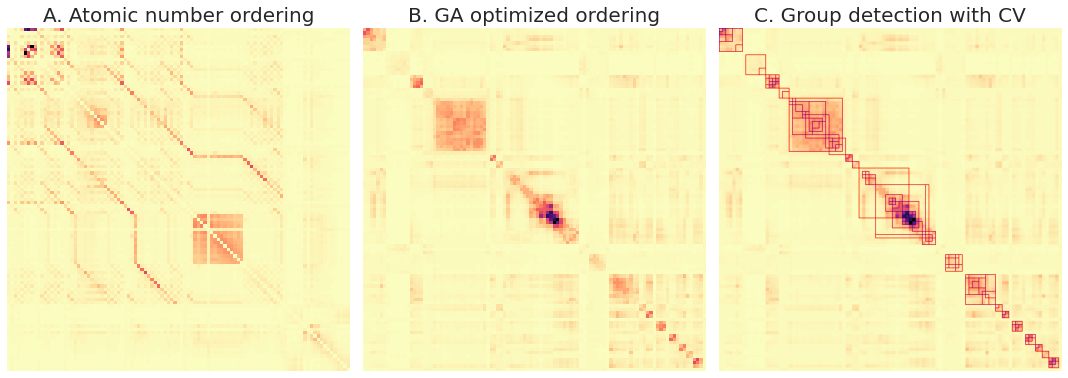

In [4]:
def getGroups_CV(yr,ind,show=False,th=10,b=1,blur_sz=7,ups=5,max_grp=20):
    """Use computer vision algorithms to find blocks of 
    similar elements in the diagonal of similarity matrix"""
    # Obtain simetrized and reshuffled matrix using year=yr and ind-th ordering
    P = plot_simMat_yr(simMat_yr,yr,min_yr=min_yr,raw=False,scale=15,ordering=Indivs_yr[yr][ind],show=False)

    # Set diagonal elements equal to avg of sorroundings, so edge is clearer
    idx = np.diag_indices(P.shape[0]-1)
    P[idx] = (P[idx[0],idx[1]+1] + P[idx[0],idx[1]-1])/2

    ## Start processing image
    
    # Convert matrix values into integers btwn 0-255
    img = np.rint(((P/np.max(P))*255)).astype(np.uint8)
    
    # Upsample: Increase num. pixels by duplicating each pixel locally
    US_FACT = ups # Upsample factor
    upsamp = cv2.resize(img,dsize=(img.shape[0]*US_FACT,img.shape[1]*US_FACT),
                        interpolation=cv2.INTER_NEAREST)  
    
    # Blur operation. Avg to fade some spurious edges
    blur = cv2.medianBlur(upsamp, blur_sz)
    
    # Add padding, so the image is framed and groups to the edges can be detected
    padd = cv2.copyMakeBorder(blur, 1,1,1,1, cv2.BORDER_CONSTANT, None, 0)

    # Detect edges with Canny algorithm
    canny = cv2.Canny(padd, th , th + b)
    
    # Find rectangles
    cnts = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)[1]

    cp=upsamp.copy()
    final_cnts = []
    for c in cnts:  # Loop through found contours
        x,y,w,h = cv2.boundingRect(c)
        # Conditions: Square on the diagonal, below certain size, above certain size
        if x==y and w < max_grp*US_FACT and w > US_FACT:
            final_cnts.append(c)
            if show:  # Draw rectangles on image
                cv2.rectangle(cp, (x//US_FACT *US_FACT, y//US_FACT *US_FACT),
                              ((x + w)//US_FACT *US_FACT, (y + h)//US_FACT *US_FACT), (255,0,0), 1)

    if show:
        cmap = sns.color_palette("magma_r", as_cmap=True)
 
        fig,ax = plt.subplots(1,3,figsize=(15,9))
        #ax[0].imshow(blur,cmap=cmap)
        #ax[0].set_title('Blurred')
        #
        #ax[1].imshow(canny,cmap=cmap)
        #ax[1].set_title('Canny edge detection')
        #
        #ax[2].imshow(cp,cmap=cmap)
        #ax[2].set_title('Original with found blocks')
        P0 = plot_simMat_yr(simMat_yr,yr,min_yr=min_yr,raw=False,scale=15,show=False)
        ax[0].set_title("A. Atomic number ordering" ,fontsize=20)
        ax[0].imshow(P0,cmap=cmap)
        ax[1].set_title("B. GA optimized ordering"  ,fontsize=20)       
        ax[1].imshow(P,cmap=cmap)
        ax[2].set_title("C. Group detection with CV",fontsize=20)        
        ax[2].imshow(cp,cmap=cmap)
        
        
        for i in range(3):
            ax[i].axis('off')
        plt.tight_layout()
        #plt.show()
        plt.savefig("../Data/Results/GroupDetect.png",dpi=300,bbox_inches="tight")
        
        
    # Now let's extract the actual groups from the squares
    seq = genToElem(Indivs_yr[yr][ind])
    grps = {} # Do as a dict so repeated entries are not added
    
    covered = np.ones(P.shape[0])  # Array to store which positions have been covered
    for c in final_cnts:  # Loop through found rectangles
        x,y,w,h = cv2.boundingRect(c)
        st = seq[x//US_FACT:x//US_FACT+w//US_FACT]  # Add mins and maxs to include border of square too
        
        covered[x//US_FACT:x//US_FACT+w//US_FACT] = 0  # These positions are covered already
        # Add group only if it contains more than one element
        if len(set(st))>1:  
            grps[str(set(st))] = set(st)
            
    # Now form groups of consecutive elements that aren't covered by any square
    p = np.array(seq[:P.shape[0]])[covered.astype(bool)]
    
    c,count=0,False
    lens=[]
    for d in np.diff(covered):
        if d==1:      c+=1; count=True
        if d==0 and count:  c+=1
        if d==-1: lens.append(c); c=0; count=False
            
    cum=0
    for l in lens:
        if l>1:
            st=p[cum:cum+l]
            grps[str(set(st))] = set(st)
        cum+=l
    
    return list(grps.values())

yr=2016
ind=19
th=10
gs = getGroups_CV(yr,ind,show=True,th=th,b=10,blur_sz=13,ups=10)

## Results of using these algorithms depend on a few parameters:

        
<font color="red">
    
- Upsampling factor
- Blurring window size
- From Canny algorithm
    - Hard threshold (th)
    - Threshold width (b)

<font color="black">
    
These can be manually tuned for an image in particular, but that misses the whole point.

#### Now we should design an algorithm that considers a range of results coming from several sets of parameters. 

Naturally, as `hard threshold` decreases, more edges are detected. As observed above, this increases the amount of "groups" found, but also introduces more spurious results from noise in the matrices. Our algorithm could start from this more sensitive picture, and iteratively discard groups using information from higher thresholds.

We should as well have some way to deal with nestings. However this is an issue that may dissapear once results from all 20 PTRs for a year have been considered, which is supposed to reduce noise leaving only the most important features, and thus groups.

<font color='green'>
<br>

Additionally we need an algorithm that can generalize to different years, which is important as different years have different amount of elements (thus size of matrix).

<font color="blue">
    
# Ideas:

- Work with an imperfect algorithm, while postprocessing of all the packs of groups will make sure results capture the common things there.
- Give more relevance to orderings with a better fitness score?


- For each year, for each ordering:
    - Produce a range of possible packs of groups, each one with different parameters (th, b, blur, upsamp). 
    - Assign relative importances to each of these packs depending on the parameters?
    - Two options:
        - Average out these to return a clean pack of groups representing the given individual.
        - Return a single pack containing all groups found. Averaging is then done with all groups found.
        
<font color="red">
    
### In any case, every idea leads to the averaging out of groups.

---

# Averaging out.

Or in prettier terms, statistical noise reduction.

### Idea: First, for each group `g0` in a pack, select the most similar group in the other packs
#### How to define similarity?

Consider intersection and length of groups.

If comparing `g0` with some other group `g1`, could use:

$$M_1 = \frac{|g0 \cap g1|}{|g0|} $$

or


$$M_2 = \frac{|g0 \cap g1|}{\sqrt{|g0|*|g1|}} $$

or

Semejanza Tanimoto
$$M_3 = \frac{|g0 \cap g1|}{|g0\cup g1|} $$

$M_1$ only takes into account length of intersection and length of `g0`, while $M_2$ takes into account length of `g1` as well.

$M_2$ looks better as it helps discard groups too disimilar in size.

Example: 


g0 = {'Rh', 'Mn', 'La', 'Fe'}

Most similar groups in pack2:

    M1     M2      Group

    1.000  1.000   A={'Rh', 'Mn', 'La', 'Fe'}
   
    0.750  0.750   B={'Rh', 'Mn', 'Fe', 'Cd'}
    
    1.000  0.516   C={'Rh', 'Co', 'Ni', 'Mg', 'Mn', 'La', 'Cd', 'Zn', 'Sr', 'Ca', 'Ba', 'Cu', 'Pb', 'Pd', 'Fe'}
    
For $M_1$, C is to `g0` as similar as A, as C is larger (thus higher prob. of finding any element). But for $M_2$, they're quite disimilar, discarding C. Let's stick to $M_2$.

#### Next:

Now, for each group candidate, we have a set of similar groups. Next step is to produce a single group out of such collection of groups, which in the end will count as the smoothening or averaging out we were looking for.

For that, a voting mechanism will be used: If an element is in at least 50% of the groups in the set, then such element will make it to the new smoothened group.

Example:

    Compare to {'Sr', 'Ba'}

    In pack 0: M2 = 1.000                   {'Sr', 'Ba'}

    In pack 1: M2 = 1.000                   {'Sr', 'Ba'}

    In pack 2: M2 = 0.707       {'Sr', 'Ca', 'Mg', 'Ba'}

    In pack 3: M2 = 0.707       {'Sr', 'Ca', 'Mg', 'Ba'}

    In pack 4: M2 = 0.707       {'Sr', 'Ca', 'Mg', 'Ba'}

    In pack 5: M2 = 0.632 {'Sr', 'Ca', 'Ba', 'Pb', 'Pd'}

    In pack 6: M2 = 0.632 {'Sr', 'Ca', 'Ba', 'Pb', 'Pd'}

    In pack 7: M2 = 0.632 {'Sr', 'Ca', 'Ba', 'Pb', 'Pd'}

The resulting group will then be: `{'Sr', 'Ca', 'Ba'}`.

The average $M_2$ can be reported as a measure of the degree of general agreement. 

In [3]:
def avg1(grps):
    """Average out a list of groups. 
    Given a list of sets, return a unique set containing the elements 
    present in at least 50% of the input sets"""
    
    # Join them, then count number of times each element appears
    join = []
    for l in grps:        join += list(l)
    
    # Get list of uniq elems, then count number of appearances of each
    uniq = set(join)
    accept = len(grps)//2  # Acceptance threshold

    final_grp = []
    for e in uniq:
        if join.count(e) >= accept:  # If num appear > threshold, add to group
            final_grp.append(e)
            
    return set(final_grp)

# Example
grps_ex =  [{'Sr', 'Ba'}, 
            {'Sr', 'Ba'},
            {'Sr', 'Ca', 'Mg', 'Ba'},
            {'Sr', 'Ca', 'Ba', 'Pb', 'Pd'}]

avg1(grps_ex)

{'Ba', 'Ca', 'Sr'}

### In general, the algorithm for "smoothening" groups looks like this:


<img src="../inf/set_smooth_algo.png" width="700">

<font color="red">
    
This is performed on each individual on a given year, and each $P_g$ corresponds to a unique set of CV parameters, returning a set of groups for every individual.

The 20 sets of groups (one for each individual) are then passed through a similar algorithm to return a final list of groups, corresponding to that particular year.

In [5]:
# As an example, let's generate an Initial state starting from individual #9 from year 2016
yr,ind=1970,9

# Generate 81 different packs of groups, using different combinations of parameters
InitState = []
for upsamp in [3,9,13]:
    for th in [1,10,50]:
        #for b in [1,10,20]:
        b=1
            #for blur_w in [7,9,11]:
        blur_w = 11
        gs = getGroups_CV(yr,ind,show=False,th=th,b=b,blur_sz=blur_w,ups=upsamp)
        InitState.append(gs)

In [10]:
def M2(A1,A2):         
    A1,A2 = set(A1),set(A2)
    return len(A1.intersection(A2))/np.sqrt(len(A1)*len(A2))

def M3(A1,A2):         
    A1,A2 = set(A1),set(A2)
    return len(A1.intersection(A2))/len(A1.union(A2))

def mainIter(InitState, NIters=1,sem=M2):
    """Implement the main iteration of algorithm. 
    Produce agreement sets among various CV parameters."""    
    CurrState = InitState.copy()
    
    for Iter in range(NIters):
        mean_m2 = 0 # Keep track of mean similarity
        FinalState = []
            
        for g,Pg in enumerate(CurrState):  # For each pack in InitState
            Pg_smooth = {}          # Dict to store the updated version of InitState (dict so no repeats)
            for Ai in Pg:                  # For each group in pack Pg
                sim_grps = []  # Store most similar groups to Ai
                sim_grps_score = [] # Store similarity score (M2)

                # Loop over all packs, excluding Pg
                for i,pck in enumerate(CurrState): 
                    if i!=g:
                        # Best match found in this pack
                        most_sim,best_m2 = None,0

                        for Aj in pck: # Then for every group in such pack 
                            #Compare how similar Ai is to Aj
                            if len(Ai)==0 or len(Aj)==0: print(Ai,Aj)
                            m2 = sem(Ai,Aj)
                            if m2>best_m2: most_sim = set(Aj); best_m2 = m2

                        if most_sim:  # If not None
                            sim_grps.append(most_sim)
                            sim_grps_score.append(best_m2)

                Avgd_Ai = avg1(sim_grps)
                if len(Avgd_Ai)>1:      Pg_smooth[str(sorted(Avgd_Ai))] = Avgd_Ai
                
            # Before appending to FinalState, clean repeated sets 
            FinalState.append(list(Pg_smooth.values()))  # Add smoothened Pg to Final state
            mean_m2 += np.mean(sim_grps_score)
            
        CurrState = FinalState.copy()  # Set current state to the newly formed state
        if Iter > 1:
            if mean_m2/len(FinalState) == meanM2: break
        meanM2 = mean_m2/len(FinalState)
        print(f"mean M2 = {meanM2:.3f} after {Iter+1} iters.")
        
        
        
    def getUnique(FState):
        """Input: list of lists of sets  [ [{},{},...], [{},{},...], ...]
        Return a single list containing all unique sets"""
        Out = []
        for l in FState: Out += l # Concatenate all resulting groups
        # Filter for only unique
        Out_d = {}
        for l in Out:
            Out_d[str(sorted(l))] = l
        return list(Out_d.values())
        
    Return = getUnique(FinalState)
    TotalUniqInitState = getUnique(InitState)

    print(f"Loop finished after {Iter+1} iterations.")
    print(f"\t ** InitState contained {len(TotalUniqInitState)} unique groups.")
    print(f"\t ** FinalState contains {len(Return)}\n")
    return Return

In [10]:
s = mainIter(InitState, NIters=5,sem=M2)

mean M2 = 0.709 after 1 iters.
mean M2 = 0.931 after 2 iters.
mean M2 = 0.948 after 3 iters.
Loop finished after 4 iterations.
	 ** InitState contained 139 unique groups.
	 ** FinalState contains 44



### Our algorithm is now mounted. Finally, let's do the same but with the results obtained from each individual for a given year, to get a final result for that year.

## With the algorithms all mounted, we need to find good sets of CV parameters to use, so that results are much more robust.

Good parameters will probably be different from year to year as size of matrices as well as pixel intensity vary. Test this and if necessary find different sets of parameters for different periods.

---

First off: Explore interplay between `blur_sz` and `ups` as these two are closely related and both correspond to preprocessing before edge detection, so they control the `Blurred` image.

Apparently, the higher the upsampling `ups`, the better the results, but also we get a larger image so algorithm is much slower. Appropriate values for `blur_sz` should be higher, but relatively close to `ups`. Let's adopt as a rule 0 $\leq$ `blur_sz` - `ups` $\leq$ 10, with `ups` $\geq$ 15. This shows an acceptable performance over the whole range of years, so we'll stick to it.

Now, explore `th` and `b`. To be clear: `th` + `b` is a hard threshold for the value of the gradient of the image, meaning that if gradient G $\geq$ `th` + `b`, it is automatically detected as an edge.

If `th` $\leq$ G $\leq$ `b`, then decision is made based on connectivity pattern.


Let's try and switch parameters, so we deal only with hard threshold and lower threshold, so that ht = th + b, and lt = th, then b = ht-th.

With this we can test if in our case we actually require two parameters, or can leave it down to just the hard threshold.

---

Influence of lower threshold seems to be minimal up to some point. e.g. if `ht` = 50, influence of `lt` is minimal for values of `lt` $\leq$ 40, but becomes important as `lt` approaches `ht`. Take away is that `lt` can be anything not too close to `ht`, leaving space for the soft criterium of Canny's algo. We could stick to the rule `ht` - `lt` $\geq$ 10, which in practice reduces these two parameters to only one, `ht`.

- With `ht` low (< 50), influence of `lt` is negligible, for higher values of `ht`, `lt` becomes more important as most of the rejected edge candidates are sent for a second revision under the soft criterium.
To avoid all this, we could just set low values of `ht`, say below 40.

- It looks promising to use low values of `lt`, as it contributes with more "wild" groups, as the criterium becomes easier to pass.

#### High values of lt detect very strong squares only, while lower values allow to detect more subtle groups.

#### Summary on lt and ht:
- `ht` should be set to values below, or can even be set to 40.
- `lt` can be anything between 0 and `ht`, every different value contributes with different and interesting findings.

## Summary

- `ups` $\geq$ 15
- 0 $\leq$ `blur_sz` - `ups` $\leq$ 10
- `ht` ~ 40
- 0 $\leq$ `lt` $\leq$ `ht`

In [11]:
def smoothForYear(yr):
    """Run two instances of smoothing algorithm:
        1. For a range of parameters, run algo. to obtain list of groups attached to individual i
        2. Run algo. over all 20 lists of groups, one per individual.
        
    TO-DO: Find good combinations of parameters, so results are reproducible + CV is reliable"""
    
    InitState_year = []
    for ind in range(20):
        # Generate different packs of groups, using different combinations of parameters
        InitState = []

        ups = 15
        ht = 40
        
        N_lt = 10
        # Make low values of lt (exponentially) more likely
        prob = np.exp(-np.arange(0,ht)/20)
        prob = prob/np.sum(prob) 
        for blur_sz_add in range(2,10,2): # let blur_sz = ups + 2, 4, 6, ... 
            for lt in np.random.choice(np.arange(0,ht),size=N_lt,p=prob):
                # ^^ A random sample of values, between 0 and ht-1 
                blur_sz = ups + blur_sz_add
                
                b = ht-lt
                th = lt
                
                gs = getGroups_CV(yr,ind,show=False,th=th,b=b,blur_sz=blur_sz,ups=ups)

                ### Check len of sets
                for i in gs:
                    if len(i)<2: print(i)

                InitState.append(gs)

        # Now apply algorithm to smoothen sets
        print(f"Smoothening ind = {ind}...")
        s_ind = mainIter(InitState, NIters=10)
        InitState_year.append(s_ind)

    print("Now processing results from all individuals")
    return mainIter(InitState_year, NIters=10)

yr = 2016
#f = smoothForYear(yr)
#f

In [8]:
def getMostSimTo(g, bag):
    """Return group in `bag` that is most similar to group `g`, alongside similarity."""
    
    bestM2,bestG = 0,None
    for g1 in bag:
        score = M2(g,g1)
        if score>=bestM2:
            bestM2=score; bestG=g1
    return bestG,bestM2       
    

## First: Find new groups
# Defined as groups which share no significant similarity to any group in the year before.

threshNew = 0.7
newGrps = []

for yr in range(1802,2016,2):
    if yr==1802:    grps_yr6bf = grps[1800]
    elif yr==1804:  grps_yr6bf = grps[1800] + grps[1802]
    else:           grps_yr6bf = grps[yr-2]+grps[yr-4]+grps[yr-6]   # All groups found within 6 yrs in the past
    
    grps_yrCur = grps[yr] # Next year
    
    # For every group in yr X, find most similar group in yr X-2,X-4,X-6 
    for g in grps_yrCur:
        G,sim = getMostSimTo(g, grps_yr6bf)
    
        if sim <= threshNew:
            newGrps.append((g,yr))  # If new group g is found, append g and `year of discovery`
            
newGrps

[({'Ag', 'H', 'K', 'Na'}, 1802),
 ({'Ba', 'Ca', 'Co', 'Cu'}, 1802),
 ({'Ba', 'Ca', 'Co', 'Sn'}, 1802),
 ({'Al', 'As', 'C', 'P', 'S'}, 1802),
 ({'Al', 'As', 'C', 'P', 'Pt', 'S'}, 1802),
 ({'Ir', 'U'}, 1804),
 ({'Ag', 'C', 'Co', 'Cu', 'Fe', 'H', 'Hg', 'K', 'Na', 'Pt', 'Rh', 'Zn'}, 1804),
 ({'Ag', 'C', 'Ca', 'Co', 'Cu', 'Fe', 'H', 'Hg', 'K', 'Na', 'Pt', 'Rh', 'Zn'},
  1804),
 ({'Ba', 'Ca', 'Pb'}, 1804),
 ({'Ba', 'Pb', 'Pd'}, 1806),
 ({'Ag', 'Au', 'C', 'Ni', 'Pt', 'Rh', 'Zn'}, 1806),
 ({'Cl', 'H', 'I', 'K', 'N', 'Na', 'O'}, 1806),
 ({'Be', 'Sn'}, 1808),
 ({'Cl', 'F', 'I'}, 1810),
 ({'Cr', 'O', 'S', 'Te'}, 1810),
 ({'C', 'Mg', 'N'}, 1810),
 ({'Bi', 'Mg'}, 1812),
 ({'Co', 'Hg', 'Ni', 'Pd'}, 1814),
 ({'Ti', 'U', 'Zr'}, 1814),
 ({'B', 'F'}, 1814),
 ({'Co', 'Fe', 'Hg', 'Ni', 'Pd'}, 1814),
 ({'Ba', 'Ca', 'Sr', 'Zn'}, 1816),
 ({'Te', 'W'}, 1816),
 ({'Ni', 'Pd', 'Pt'}, 1818),
 ({'C', 'S', 'Se'}, 1818),
 ({'Bi', 'Rh'}, 1818),
 ({'Ce', 'Li', 'Os'}, 1818),
 ({'Be', 'Mn'}, 1820),
 ({'Bi', 'Os'}, 1822)